# Data

**Load thư viện cần thiết**

In [4]:
!pip install whoosh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import nltk
import time
import pickle
import matplotlib.pyplot as plt
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.util import ngrams
from copy import deepcopy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Kết nối với google drive**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
cd '/gdrive/MyDrive/CS419/Homework/Cranfield Assignment'

**Đọc các file trong cranfield**

In [ ]:
import os
dir_monhoc = '/gdrive/MyDrive/CS419/Homework/Cranfield Assignment'
dir_cranfield = os.path.join(dir_monhoc,'Cranfield')
dir_Test = os.path.join(dir_monhoc,'TEST')
dir_query = os.path.join(dir_Test,'query.txt')
dir_res = os.path.join(dir_Test,'RES')

In [ ]:
docs = []
for file in sorted(os.listdir(dir_cranfield),key = lambda x: int(x[:-4])):
  f = open(os.path.join(dir_cranfield,file),'r')
  doc = f.readlines()
  if len(doc) > 0:
    docs.append(doc[0])
  else:
    docs.append('')

In [ ]:
querys = []
f = open(dir_query,'r')
query = f.readlines()
for q in query:
  if len(q) > 0:
    q = q.split()
    querys.append(' '.join(q[1:]))

In [ ]:
res_matrix = np.zeros((len(querys),len(docs)))
iQ = 0
for file in sorted(os.listdir(dir_res),key = lambda x: int(x[:-4])):
  f = open(os.path.join(dir_res,file),'r')
  inp = f.readlines()
  for i in range(len(inp)):
    inp[i] = inp[i].replace('\t',' ')
    inp[i] = inp[i].replace('\n','')
    inp[i] = inp[i].split()[:2]
    doc = int(inp[i][1]) - 1
    res_matrix[iQ,doc] = 1
  iQ += 1

In [ ]:
def save_to_excel(docs,name):
  vocab = {}
  for doc in docs:
    for word in doc.split():
      if word not in vocab:
        vocab[word] = 0
      vocab[word] += 1
  data = {'word': vocab.keys(), 'freq': vocab.values()}
  df = pd.DataFrame(data)
  df.to_excel(f"{name}.xlsx")
  

# Extract terms from documents

In [ ]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stoplist = stopwords.words("english")

In [ ]:
def isNumber(s):
  try:
      k = int(s)
      if k == float(s):
        return True
      return False
  except ValueError:
      return False

**Get term in a test string**

In [ ]:
test_string = "Delivery of silver arrived in a silver truck"
print(f'Original string: \t\t\t{test_string}')
toks = word_tokenize(test_string)
tok_lower = []
tok_remove_punctuation = []
tok_remove_stopword_number = []
tok_stemming = []
print(f'Token extractor: \t\t\t{toks}')
for i in range(len(toks)):
  tok_lower.append(toks[i].lower())
  tok_remove_punctuation.append(tok_lower[-1].translate(str.maketrans('', '', punctuation)))
  if len(tok_remove_punctuation[-1]) > 0:
    if isNumber(tok_remove_punctuation[-1]) or tok_remove_punctuation[-1] not in stoplist:
      tok_remove_stopword_number.append(tok_remove_punctuation[-1])
      tok_stemming.append(ps.stem(tok_remove_punctuation[-1]))
print(f'Token after lower case: \t\t{tok_lower}')
print(f'Token after remove punctuation: \t{tok_remove_punctuation}')
print(f'Token after remove stopword and number: {tok_remove_stopword_number}')
print(f'Token after stemming: \t\t\t{tok_stemming}')
print(f'Final Term: \t\t\t\t{tok_stemming}')


**Support Function**

In [ ]:
def get_terms(doc):
  terms = []
  toks = word_tokenize(doc)
  for tok in toks:
    tok = tok.lower()
    tok = tok.translate(str.maketrans('', '', punctuation))
    if len(tok) == 0 or isNumber(tok) or tok in stoplist:
      continue
    terms.append(ps.stem(tok))
    # terms.append(lemmatizer.lemmatize(tok))
  return terms

In [ ]:
def text_analyzis(docs):
  DD = []
  for doc in docs:
    token = get_terms(doc)
    DD.append(token)
  return DD

In [ ]:
def create_freq_dic(DD):
  allterms = []
  for itm in DD:
    allterms.extend(itm)
  fd = FreqDist(allterms)
  return fd

**Get term in docs and query**

In [ ]:
DD = text_analyzis(docs)
fd = create_freq_dic(DD)
query_terms = text_analyzis(querys)

**Numbers of term and frequency**

In [ ]:
len(fd)

In [ ]:
sum(fd.values())

**Statistic Term Frequency**

In [ ]:
values,counts = np.unique(list(fd.values()),return_counts = True)

In [ ]:
fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
plt.bar(values, list(counts), color ='g', width = 2)
 
plt.xlabel("Term Frequency")
plt.ylabel("Numbers")
plt.title("Numbers of Term Frequency")
plt.xlim(1,100)
plt.show()

**Compare between original data and terms**

In [ ]:
dd = []
for d in docs:
  dd.append(d.split())

In [ ]:
fd_docs = create_freq_dic(dd)

In [ ]:
labels = ['Unique Words', 'Total Words']
word_unique = [len(fd_docs),sum(fd_docs.values())]
total_word = [len(fd),sum(fd.values())]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (5,5))
rects1 = ax.bar(x - width/2, word_unique, width, label='Documents',color = '#7eb54e')
rects2 = ax.bar(x + width/2, total_word, width, label='Terms',color = 'cornflowerblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Amount')
ax.set_title('Compare between Documents and Terms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [ ]:
freq_range = {
    '1->50':0,
    '50->500': 0,
    '500->1000': 0,
    '> 1000': 0
}

for freq in fd.values():
  if 1 <= freq <= 50: freq_range['1->50'] += 1
  elif 50 < freq <= 500: freq_range['50->500'] += 1
  elif 500 < freq <= 1000: freq_range['500->1000'] += 1
  else: freq_range['> 1000'] += 1

In [ ]:
freq_range['1->50']


In [ ]:
freq_range['50->500']


In [ ]:
freq_range['500->1000']


In [ ]:
freq_range['> 1000'] 

In [ ]:
fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
plt.bar(freq_range.keys(), freq_range.values(), color ='#7eb54e', width = 0.8)

In [ ]:
len(fd)

# Measure Function

In [ ]:
def interpolation_11_points_1_query(ranked_query,res_query,measure_mode = 'TF_IDF',doc_range = 500):
  interest_points = np.linspace(0,1,11)
  if measure_mode == 'TF_IDF':
    nums_doc = np.count_nonzero(ranked_query)
    ranked_index = np.argsort(-ranked_query)[:nums_doc]
  elif measure_mode == "whoosh":
    ranked_index = np.array(ranked_query)[:doc_range]
  else:
    ranked_index = np.argsort(-ranked_query)[:doc_range]
  res = np.where(res_query > 0)
  true_docs_positions = np.where(np.in1d(ranked_index, res) == True)[0] + 1
  nums_true = np.arange(0,len(true_docs_positions)) + 1 
  recall = nums_true / len(true_docs_positions)
  precision = nums_true / true_docs_positions
  if len(recall) == 0:
    return True
  min_recall_interest_points = [np.where(recall >= interest_points[i])[0][0] for i in range(11)]
  precision_11_points = [np.amax(precision[min_recall_interest_points[i]:]) for i in range(11)]
  average_precision_11_points = np.mean(precision_11_points)
  return average_precision_11_points

In [ ]:
def mean_interpolations_11_points(ranked_matrix,res_matrix,measure_mode = 'TF_IDF',doc_range = 500):
  mean_interpolations_11_points = []
  for ranked_query, res_query in zip(ranked_matrix, res_matrix):
    interpolations_11_points = interpolation_11_points_1_query(ranked_query, res_query, measure_mode,doc_range)
    mean_interpolations_11_points.append(interpolations_11_points)
  return np.mean(mean_interpolations_11_points)

In [ ]:
def AP_measure_for_one_query(ranked_query,res_query,measure_mode = 'TF_IDF',doc_range = 500):
  if measure_mode == 'TF_IDF':
    nums_doc = np.count_nonzero(ranked_query)
    ranked_index = np.argsort(-ranked_query)[:nums_doc]
  elif measure_mode == "whoosh":
    ranked_index = np.array(ranked_query)[:doc_range]
  else:
    ranked_index = np.argsort(-ranked_query)[:doc_range]
  res = np.where(res_query > 0)
  true_docs_positions = np.where(np.in1d(ranked_index, res) == True)[0] + 1
  if len(true_docs_positions) == 0:
    return 0
  nums_true = np.arange(0,len(true_docs_positions)) + 1 
  average_precision = np.mean(nums_true / true_docs_positions)
  return average_precision

In [ ]:
def MAP_measure(ranked_matrix,res_matrix,measure_mode = 'TF_IDF',doc_range = 500):
  MAP = []
  for ranked_query, res_query in zip(ranked_matrix, res_matrix):
    AP_score = AP_measure_for_one_query(ranked_query, res_query,measure_mode,doc_range)
    MAP.append(AP_score)
  return np.mean(MAP)

In [ ]:
class Measure:
  def __init__(self,ranked_matrix,res_matrix,mode = 'TF_IDF',doc_range = 500):
    self.ranked_matrix = ranked_matrix
    self.res_matrix = res_matrix
    self.mode = mode
    self.doc_range = doc_range
    self.recall_score = []
    self.precision_score = []
    self.MAP_score = MAP_measure(ranked_matrix,res_matrix,mode,doc_range)
    self.M11_score = mean_interpolations_11_points(ranked_matrix,res_matrix,mode,doc_range)
  
  def recall_precision_score(self):
    for predict_score,true_score in zip(self.ranked_matrix,self.res_matrix):
      if self.mode != 'whoosh':
        nums_doc = np.count_nonzero(predict_score)
        if self.mode == 'prob': nums_doc = self.doc_range
        ranked_doc = np.argsort(-predict_score)[:nums_doc]
      else:
        ranked_doc = np.array(predict_score)
      true = np.where(true_score > 0)
      true_docs_positions = np.where(np.in1d(ranked_doc, true) == True)[0] + 1
      recall_score = len(true_docs_positions) / len(true[0])
      try:
        precision_score = len(true_docs_positions) / len(ranked_doc)
      except:
        precision_score = 0
      self.recall_score.append(recall_score)
      self.precision_score.append(precision_score)
  
  def get_score(self):
    self.recall_precision_score()
    print(f'Recall score: {np.mean(self.recall_score)}')
    print(f'Precision score: {np.mean(self.precision_score)}')
    print(f'MAP score: {self.MAP_score}')
    print(f'Mean interpolation 11 points: {self.M11_score}')

  def return_score(self):
    if self.recall_score == []:
      self.recall_precision_score()
    return {'recall': np.mean(self.recall_score),'precision': np.mean(self.precision_score),'MAP': self.MAP_score,'11 points': self.M11_score}

In [ ]:
def plot_MAP_M11(title,ranked_matrix,res_matrix,mode = 'TF_IDF'):
    MAP_inter = []
    MAP_11_inter = []
    N = np.linspace(20,1400,int(1400/20),dtype = int)
    for n in N:
      bigram_inter_score = Measure(ranked_matrix,res_matrix,mode,doc_range = n)
      score = bigram_inter_score.return_score()
      MAP_inter.append(score['MAP'])
      MAP_11_inter.append(score['11 points'])
    plt.figure(figsize = (5,5), dpi = 80)

    plt.plot(N, MAP_inter, 'r-', label = 'Non Interpolated')
    plt.plot(N, MAP_11_inter, 'b-', label = 'Interpolated')

    plt.ylim(min(MAP_inter[-1],MAP_11_inter[-1]),max(MAP_inter[0],MAP_11_inter[0]))

    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)

    plt.xlabel('N First Retrieval Documents', fontsize = 12)
    plt.ylabel('Score',fontsize = 12)

    plt.title(title)
    plt.legend(loc = 'best', fontsize = 12)

# Vector Space Model by Term - Doc Matrix

## Support Function

In [ ]:
def create_term_doc_index(docs,fd):
    term_doc = {}
    N = len(fd)
    M = len(docs)

    # Count numple of term in each doc
    for index_doc in range(M):
      for word in docs[index_doc]:
        if word in fd:
          if word not in term_doc:
            term_doc[word] = {}
          if index_doc not in term_doc[word]:
            term_doc[word][index_doc] = 0
          term_doc[word][index_doc] += 1
    return term_doc

In [ ]:
def create_collect_matrix(term_doc_index):
  # if word in freq_matrix --> collect[doc][word] = 1 else 0
  # Sum of docs has word

  collect_matrix = {key:len(term_doc_index[key]) for key in term_doc_index.keys()}
  return collect_matrix

In [ ]:
def tf_matrix(term_doc_index,n_docs, smart = True):
  # max_freq = np.zeros(n_docs)
  # for doc_freq in term_doc_index.values():
  #   for doc in doc_freq.keys():
  #     max_freq[doc] = max(max_freq[doc],doc_freq[doc])
  if smart:
    for term in term_doc_index:
      for doc in term_doc_index[term].keys():
        # term_doc_index[term][doc] /= max_freq[doc]
        if term_doc_index[term][doc] != 0:
          term_doc_index[term][doc] = 1 + np.log(term_doc_index[term][doc])
        else:
          term_doc_index[term][doc] = 1

In [ ]:
def idf_matrix(collect_matrix,N_docs, smart = True):
  for term in collect_matrix.keys():
    if smart:
      collect_matrix[term] = np.log((N_docs + 1) / (collect_matrix[term] + 1))
      # collect_matrix[term] = np.log(N_docs / collect_matrix[term])
      collect_matrix[term] += 1
    else:
      collect_matrix[term] = 1 / collect_matrix[term]

In [ ]:
def tfidf_matrix(term_doc_index,collect_matrix,normalize):
  for term in term_doc_index.keys():
    for doc in term_doc_index[term].keys():
      term_doc_index[term][doc] *= collect_matrix[term]
      term_doc_index[term][doc] /= normalize[doc]

In [ ]:
def normalize_matrix(tf,idf,n_docs):
  normalize = np.zeros(n_docs)
  for term in tf.keys():
    for doc in tf[term].keys():
      normalize[doc] += np.power(tf[term][doc],2) * np.power(idf[term],2)
  for i in range(len(normalize)):
    normalize[i] = np.sqrt(normalize[i])
  return normalize

In [ ]:
def create_ranked_matrix(tfidf_matrix,tfidf_query,M,N):
  ranked_matrix = np.zeros((M,N),dtype = float)
  for word in tfidf_matrix.keys():
    for doc in tfidf_matrix[word].keys():
      for word_q in tfidf_query.keys():
        for query in tfidf_query[word_q].keys():
          if word == word_q:
            ranked_matrix[doc,query] += tfidf_matrix[word][doc] * tfidf_query[word_q][query]
  return np.transpose(ranked_matrix)

## Build VSM

In [ ]:
smart = False
start = time.time()
N_docs = len(DD)
N_querys = len(querys)
term_doc_index = create_term_doc_index(DD,fd)
collect_matrix = create_collect_matrix(term_doc_index)
idf_matrix(collect_matrix,N_docs, smart = smart)
query_collect = deepcopy(collect_matrix)
normalize_docs = normalize_matrix(term_doc_index, collect_matrix,N_docs)
tfidf_matrix(term_doc_index,collect_matrix, normalize_docs)
query_index = create_term_doc_index(query_terms,fd)
normalize_query = normalize_matrix(query_index, query_collect,N_docs)
tfidf_matrix(query_index,query_collect, normalize_query)
ranked_matrix = create_ranked_matrix(term_doc_index,query_index,N_docs,N_querys)
end = time.time()

**Non SMART**

In [ ]:
score = Measure(ranked_matrix,res_matrix)
score.get_score()

Recall score: 0.9539935156096753
Precision score: 0.009954078481468906
MAP score: 0.22312945300447762
Mean interpolation 11 points: 0.24815978676251757


In [ ]:
print(f'Time process: {end - start}')

Time process: 23.40098762512207


**SMART**

In [ ]:
start = time.time()
N_docs = len(DD)
N_querys = len(querys)
term_doc_index = create_term_doc_index(DD,fd)
collect_matrix = create_collect_matrix(term_doc_index)
tf_matrix(term_doc_index,N_docs)
idf_matrix(collect_matrix,N_docs)
query_collect = deepcopy(collect_matrix)
normalize_docs = normalize_matrix(term_doc_index, collect_matrix,N_docs)
tfidf_matrix(term_doc_index,collect_matrix, normalize_docs)
query_index = create_term_doc_index(query_terms,fd)
tf_matrix(query_index,N_docs)
normalize_query = normalize_matrix(query_index, query_collect,N_docs)
tfidf_matrix(query_index,query_collect, normalize_query)
ranked_matrix = create_ranked_matrix(term_doc_index,query_index,N_docs,N_querys)
end = time.time()

In [ ]:
score = Measure(ranked_matrix,res_matrix)

In [ ]:
score.get_score()

Recall score: 0.9539935156096753
Precision score: 0.009954078481468906
MAP score: 0.4152546812424895
Mean interpolation 11 points: 0.44210495365042896


In [ ]:
print(f'Time process: {end - start}')

Time process: 23.30336833000183


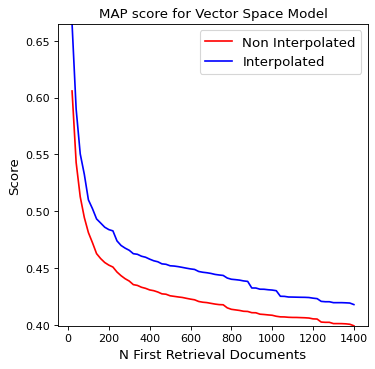

In [ ]:
plot_MAP_M11('MAP score for Vector Space Model',ranked_matrix,res_matrix,mode = 'prob')

# Language Model

In [ ]:
dd = []
for doc in DD:
  dd.append(['<s>',*doc,'</s>'])

In [ ]:
qq = []
for q in query_terms:
  qq.append(['<s>',*q,'</s>'])

## Unigram

### Support Function

In [ ]:
def get_unigram_docs(docs):
  unigram = {}
  freq = np.zeros(len(docs))
  count_freq = {}
  for index_doc,doc in enumerate(docs):
    count = {}
    for k in range(len(doc)):
      vector_word = doc[k]
      unigram[vector_word] = unigram.get(vector_word,{})
      unigram[vector_word][index_doc] = unigram[vector_word].get(index_doc,0) + 1
      count[vector_word] = count.get(vector_word,0) + 1
      freq[index_doc] += 1
    count_freq[index_doc] = {}
    for nums in count:
      count_freq[index_doc][count[nums]] = count_freq[index_doc].get(count[nums],0) + 1
  return unigram,freq

In [ ]:
def get_unigram_collection(collection):
  unigram = {}
  freq = 0
  for word in collection:
    vector_word = word
    unigram[vector_word] = unigram.get(vector_word,0) + 1
    freq += 1
  return unigram,freq

In [ ]:
def get_unigram_query(query_terms,fd):
  query_unigram = {}
  for i_q,q in enumerate(query_terms):
    for vector_word in q:
      if vector_word in fd:
        query_unigram[i_q] = query_unigram.get(i_q,{vector_word: 0})
        query_unigram[i_q][vector_word] = query_unigram[i_q].get(vector_word,0) + 1
  return query_unigram

In [ ]:
def calProbCollection(unigram_c,freq_c):
  for vector_word in unigram_c.keys():
    unigram_c[vector_word] = unigram_c[vector_word] / freq_c

In [ ]:
def calProbDocument(unigram,freq,unigram_c = None,lb = 0.4,laplace_smooth = 0,linear_interpolated = 1,alpha = 1):
  d = len(unigram)
  for vector_word in unigram.keys():
    for doc in unigram[vector_word].keys():
      if laplace_smooth:
        unigram[vector_word][doc] = (unigram[vector_word][doc] + alpha) / (freq[doc] + alpha * d)
      elif linear_interpolated:
        unigram[vector_word][doc] = lb * (unigram[vector_word][doc] / freq[doc]) + (1 - lb) * (unigram_c[vector_word])
      else:
        unigram[vector_word][doc] = unigram[vector_word][doc] / freq[doc]

In [ ]:
def create_ranked_prob(unigram_docs,unigram_q, freq, nums_docs, nums_querys,alpha = 1,unigram_collection = None, lb = None,laplace_smooth = 0,linear_interpolated = 1):
  d = len(unigram_docs)
  full_doc = np.arange(0,nums_docs,1)
  ranked_matrix = np.ones((nums_docs,nums_querys),dtype = float)
  for query_id in unigram_q.keys():
    for vector_word in unigram_q[query_id].keys():
      doc_have = []
      for doc in unigram_docs[vector_word].keys():
        ranked_matrix[doc,query_id] *= np.power(unigram_docs[vector_word][doc],unigram_q[query_id][vector_word])
        doc_have.append(doc)
      doc_not_have = np.where(np.isin(full_doc,doc_have,invert=True))[0]
      if laplace_smooth:
        prob = np.power(alpha / (freq[doc_not_have] + (alpha * d)),unigram_q[query_id][vector_word])
        ranked_matrix[doc_not_have,query_id] *= prob
      elif linear_interpolated:
        prob = np.power(alpha / (freq[doc_not_have] + (alpha * d)),unigram_q[query_id][vector_word])
        ranked_matrix[doc_not_have,query_id] *= prob
      else:
        ranked_matrix[doc_not_have,query_id] *= 0
  return np.transpose(ranked_matrix)

### Test model

#### **Laplace Smoothing**

In [ ]:
start = time.time()
unigram,freq = get_unigram_docs(dd)
calProbDocument(unigram,freq,laplace_smooth = 1)
unigram_q = get_unigram_query(qq,fd)
ranked_matrix_laplace_uni = create_ranked_prob(unigram,unigram_q,freq,1400,225,laplace_smooth = 1)
end = time.time()
time_uni_laplace = end - start

In [ ]:
print(f'Time Finish: {time_uni_laplace}')

Time Finish: 1.800081491470337


In [ ]:
unigram_laplace_score = Measure(ranked_matrix_laplace_uni,res_matrix,mode = 'prob')
unigram_laplace_score.get_score()

Recall score: 0.8989626354416007
Precision score: 0.014417777777777781
MAP score: 0.29191536064737583
Mean interpolation 11 points: 0.31950015614095506


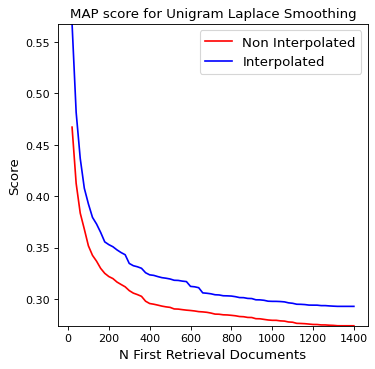

In [ ]:
plot_MAP_M11('MAP score for Unigram Laplace Smoothing',ranked_matrix_laplace_uni,res_matrix,mode = 'prob')

**Choose alpha optimize**

In [ ]:
# Run alpha from 1 -> 10
MAP_alpha = []
MAP_TREC_alpha = []
for alpha in range(1,11):
  unigram,freq = get_unigram_docs(dd)
  calProbDocument(unigram,freq,laplace_smooth = 1,alpha = alpha)
  unigram_q = get_unigram_query(qq,fd)
  ranked_matrix_laplace_uni = create_ranked_prob(unigram,unigram_q,freq,1400,225,laplace_smooth = 1,alpha = alpha)
  unigram_laplace_score = Measure(ranked_matrix_laplace_uni,res_matrix,mode = 'prob')
  MAP_alpha.append(unigram_laplace_score.MAP_score)
  MAP_TREC_alpha.append(unigram_laplace_score.M11_score)

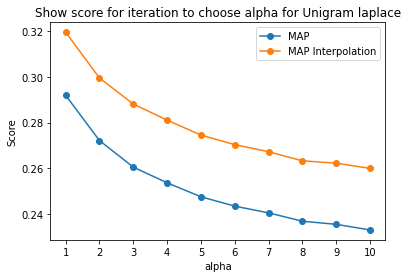

In [ ]:
alphas = [_ for _ in range(1,11)]
plt.plot(alphas,MAP_alpha,label = 'MAP',marker = 'o')
plt.plot(alphas,MAP_TREC_alpha, label = 'MAP Interpolation', marker = 'o')

plt.title("Show score for iteration to choose alpha for Unigram laplace")
plt.xlabel('alpha')
plt.ylabel('Score')
plt.xticks(alphas)
plt.legend()
plt.show()


#### **Linear Interpolation Smoothing**

In [ ]:
collection = []
for doc in dd:
  collection.extend(doc)

In [ ]:
start = time.time()
lb = 0.4
unigram,freq = get_unigram_docs(dd)
unigram_collection,freq_c = get_unigram_collection(collection)
calProbCollection(unigram_collection,freq_c)
calProbDocument(unigram,freq, unigram_collection,lb = lb)
unigram_q = get_unigram_query(qq,fd)
ranked_matrix_inter_uni = create_ranked_prob(unigram,unigram_q,freq,1400,225,lb = lb,unigram_collection = unigram_collection)
end = time.time()
time_inter_uni = end - start

In [ ]:
print(f'Time Finish: {time_inter_uni}')

Time Finish: 1.9780035018920898


In [ ]:
unigram_inter_score = Measure(ranked_matrix_inter_uni,res_matrix,mode = 'prob')
unigram_inter_score.get_score()

Recall score: 0.9072361018958294
Precision score: 0.014542222222222224
MAP score: 0.40550240687666095
Mean interpolation 11 points: 0.4342243441238851


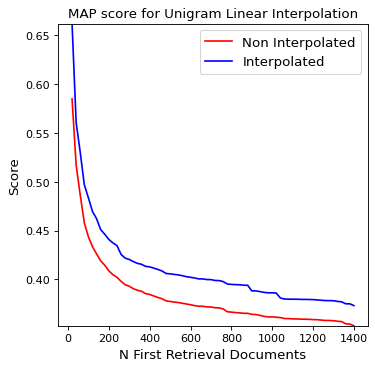

In [ ]:
plot_MAP_M11('MAP score for Unigram Linear Interpolation',ranked_matrix_inter_uni,res_matrix,mode = 'prob')

In [ ]:
# Run lambda from 0 -> 1.0, step is 0.05
MAP_alpha = []
MAP_TREC_alpha = []
Recall = []
precision = []
lbs = np.arange(0.05,1,0.05)
for lb in lbs:
  unigram,freq = get_unigram_docs(dd)
  unigram_collection,freq_c = get_unigram_collection(collection)
  calProbCollection(unigram_collection,freq_c)
  calProbDocument(unigram,freq, unigram_collection,lb = lb)
  unigram_q = get_unigram_query(qq,fd)
  ranked_matrix_inter_uni = create_ranked_prob(unigram,unigram_q,freq,1400,225,lb = lb,unigram_collection = unigram_collection)
  unigram_inter_score = Measure(ranked_matrix_inter_uni,res_matrix,mode = 'prob')
  unigram_inter_score.recall_precision_score()
  MAP_alpha.append(unigram_inter_score.MAP_score)
  MAP_TREC_alpha.append(unigram_inter_score.M11_score)
  Recall.append(np.mean(unigram_inter_score.recall_score))
  precision.append(np.mean(unigram_inter_score.precision_score))

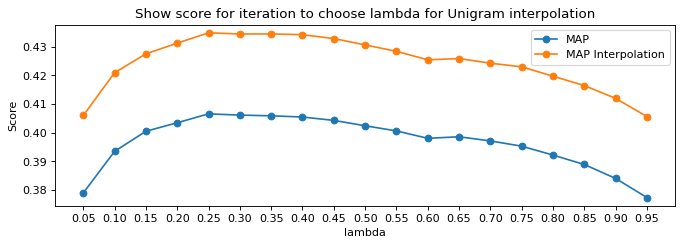

In [ ]:
plt.figure(figsize=(10, 3), dpi=80)
plt.plot(lbs,MAP_alpha,label = 'MAP',marker = 'o')
plt.plot(lbs,MAP_TREC_alpha, label = 'MAP Interpolation', marker = 'o')

plt.title("Show score for iteration to choose lambda for Unigram interpolation")
plt.xlabel('lambda')
plt.ylabel('Score')
plt.xticks(lbs)
plt.legend()
plt.show()


## Bigram


### Support Function 

In [ ]:
def get_ngram(docs,n = 2):
  freq = np.zeros(len(docs))
  bigram = {}
  unigram = {}
  for index_doc,doc in enumerate(docs):
    list_ngram = list(ngrams(doc, n))
    list_unigram = list(ngrams(doc,1))
    for vector_word in list_ngram:
      bigram[vector_word] = bigram.get(vector_word,{})
      bigram[vector_word][index_doc] = bigram[vector_word].get(index_doc,0) + 1
    for vector_word in list_unigram:
      unigram[vector_word[0]] = unigram.get(vector_word[0],{})
      unigram[vector_word[0]][index_doc] = unigram[vector_word[0]].get(index_doc,0) + 1
    freq[index_doc] = len(list_unigram)
  return unigram,bigram,freq

In [ ]:
def get_bigram_query(query_terms,fd,n = 2):
  query_bigram = {}
  for i_q,q in enumerate(query_terms):
    list_ngram = ngrams(q,n)
    query_bigram[i_q] = query_bigram.get(i_q,{})
    for vector_word in list_ngram:
      if vector_word in fd:
        query_bigram[i_q][vector_word] = query_bigram[i_q].get(vector_word,0) + 1
  return query_bigram

In [ ]:
def calBigramProb(bigram,unigram,freq_unigram,lb = 1,mode = 'laplace',alpha = 1):
  d = len(unigram)
  for vector_word in bigram.keys():
    for doc in bigram[vector_word].keys():
      if mode == 'laplace':
        bigram[vector_word][doc] = (bigram[vector_word][doc] + alpha) / (unigram[vector_word[0]][doc] + alpha * d)
      elif mode == 'interpolation':
        bigram[vector_word][doc] = lb * (bigram[vector_word][doc] / unigram[vector_word[0]][doc]) \
        + (1 - lb) * (unigram[vector_word[1]][doc] / freq_unigram[doc])

In [ ]:
def create_ranked_prob(bg_docs,bg_query,d,freq,N_docs,N_query,mode = 'laplace',unigram = None,unigram_collection = None,lb = 1,alpha = 1):
  full_doc = np.arange(0,N_docs,1)
  ranked_matrix = np.ones((N_docs,N_query),dtype = float)
  for query_id in bg_query.keys():
    for vector_word in bg_query[query_id].keys():
      doc_have = []
      for doc in bg_docs[vector_word].keys():
        ranked_matrix[doc,query_id] *= np.power(bg_docs[vector_word][doc],bg_query[query_id][vector_word])
        doc_have.append(doc)
      doc_not_have = np.where(np.isin(full_doc,doc_have,invert=True))[0]
      prob_unigram = []
      for doc in doc_not_have:
        if mode == 'laplace':
          prob_unigram.append(alpha / (unigram[vector_word[0]].get(doc,0) + alpha * d))
        elif mode == 'interpolation':
          freq_uni = unigram[vector_word[1]].get(doc,0)
          if freq_uni == 0:
            prob_unigram.append((1 - lb) * unigram_collection[vector_word[1]])
          else:
            prob_unigram.append((1 - lb) * (freq_uni / freq[doc]))
      prob_unigram = np.array(prob_unigram)
      ranked_matrix[doc_not_have,query_id] *= np.power(prob_unigram,bg_query[query_id][vector_word])
  return np.transpose(ranked_matrix)

### Test model

#### **Laplace Smoothing**

In [ ]:
start = time.time()
unigram,bigram,freq = get_ngram(dd,2)
calBigramProb(bigram,unigram,freq)
bigram_query = get_bigram_query(qq,bigram)
N_docs = len(DD)
N_query = len(query)
ranked_matrix_laplace_big = create_ranked_prob(bigram,bigram_query,len(unigram),freq,N_docs,N_query,mode = 'laplace',unigram = unigram)
end = time.time()
time_laplace_big = end - start

In [ ]:
print(f'Time Finish: {time_laplace_big}')

Time Finish: 2.354142904281616


In [ ]:
bigram_laplace_score = Measure(ranked_matrix_laplace_big,res_matrix,mode = 'prob',doc_range = 500)
bigram_laplace_score.get_score()

Recall score: 0.6175343043905551
Precision score: 0.009946666666666668
MAP score: 0.3292572232070376
Mean interpolation 11 points: 0.3973561034999369


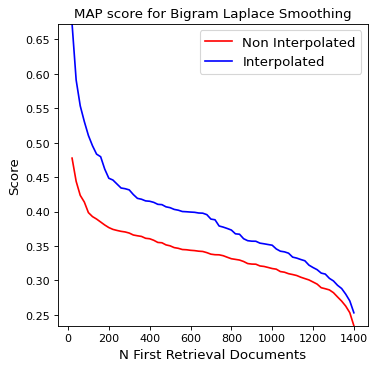

In [ ]:
plot_MAP_M11('MAP score for Bigram Laplace Smoothing',ranked_matrix_laplace_big,res_matrix,mode = 'prob')

In [ ]:
# Run alpha from 1 -> 10
MAP_alpha = []
MAP_TREC_alpha = []
for alpha in range(1,11):
  unigram,bigram,freq = get_ngram(đ,2)
  calBigramProb(bigram,unigram,freq,alpha = alpha)
  bigram_query = get_bigram_query(qq,bigram)
  N_docs = len(DD)
  N_query = len(query)
  ranked_matrix_laplace_big = create_ranked_prob(bigram,bigram_query,len(unigram),freq,N_docs,N_query,mode = 'laplace',alpha = alpha)
  bigram_laplace_score = Measure(ranked_matrix_laplace_big,res_matrix,mode = 'prob',doc_range = 500)
  MAP_alpha.append(bigram_laplace_score.MAP_score)
  MAP_TREC_alpha.append(bigram_laplace_score.M11_score)

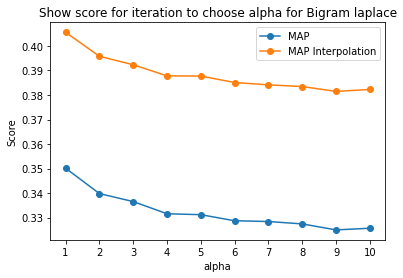

In [ ]:
alphas = [_ for _ in range(1,11)]
plt.plot(alphas,MAP_alpha,label = 'MAP',marker = 'o')
plt.plot(alphas,MAP_TREC_alpha, label = 'MAP Interpolation', marker = 'o')

plt.title("Show score for iteration to choose alpha for Bigram laplace")
plt.xlabel('alpha')
plt.ylabel('Score')
plt.xticks(alphas)
plt.legend()
plt.show()


#### **Linear Interpolation**

In [ ]:
collection_bigram = []
for doc in DD:
  collection_bigram.extend(['<s>',*doc,'</s>'])

In [ ]:
start = time.time()
lb = 0.6
unigram,bigram,freq = get_ngram(dd,2)
unigram_collection,freq_c = get_unigram_collection(collection_bigram)
calProbCollection(unigram_collection,freq_c)
calBigramProb(bigram,unigram,freq,lb = lb,mode = 'interpolation')
bigram_query = get_bigram_query(qq,bigram)
N_docs = len(DD)
N_query = len(query)
ranked_matrix_inter_big = create_ranked_prob(bigram,bigram_query,len(unigram),freq,N_docs,N_query,\
        mode = 'interpolation',lb = lb,unigram = unigram,unigram_collection = unigram_collection)
end = time.time()
time_inter_big = end - start

In [ ]:
print(f'Time Finish: {time_inter_big}')

Time Finish: 4.948253631591797


In [ ]:
bigram_inter_score = Measure(ranked_matrix_inter_big,res_matrix,mode = 'prob',doc_range = 500)
bigram_inter_score.get_score()

Recall score: 0.8555113093880434
Precision score: 0.013644444444444445
MAP score: 0.3214709856957823
Mean interpolation 11 points: 0.3383607533557423


In [ ]:
print(f'Time Finish: {time_laplace_big}')

Time Finish: 1.5477943420410156


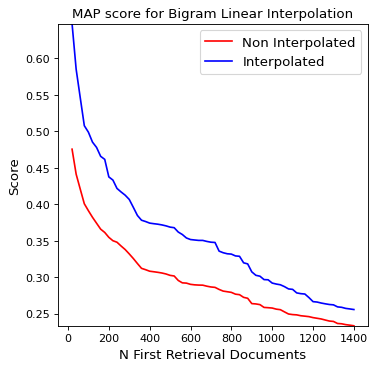

In [ ]:
plot_MAP_M11('MAP score for Bigram Linear Interpolation',ranked_matrix_inter_big,res_matrix,mode = 'prob')

In [ ]:
# Run lambda from 0 -> 1.0, step is 0.05
MAP_alpha = []
MAP_TREC_alpha = []
lbs = np.arange(0.05,1,0.05)
for lb in lbs:
  unigram,bigram,freq = get_ngram(dd,2)
  unigram_collection,freq_c = get_unigram_collection(collection_bigram)
  calProbCollection(unigram_collection,freq_c)
  calBigramProb(bigram,unigram,freq,lb = lb,mode = 'interpolation')
  bigram_query = get_bigram_query(qq,bigram)
  N_docs = len(DD)
  N_query = len(query)
  ranked_matrix_inter_big = create_ranked_prob(bigram,bigram_query,len(unigram),freq,N_docs,N_query,\
          mode = 'interpolation',lb = lb,unigram = unigram,unigram_collection = unigram_collection)
  bigram_inter_score = Measure(ranked_matrix_inter_big,res_matrix,mode = 'prob',doc_range = 500)
  MAP_alpha.append(bigram_inter_score.MAP_score)
  MAP_TREC_alpha.append(bigram_inter_score.M11_score)

In [ ]:
r_a = np.round_(MAP_alpha, decimals = 4)

In [ ]:
r_b = np.round_(MAP_TREC_alpha, decimals = 4)


In [ ]:
pd.DataFrame({'l_1': lbs,'l_2': 1 - lbs,'MAP': r_a,'MAP Interpolation': r_b})

,l_1,l_2,MAP,MAP Interpolation
0,0.05,0.95,0.3247,0.3400
1,0.10,0.90,0.3245,0.3407
2,0.15,0.85,0.3262,0.3422
3,0.20,0.80,0.3265,0.3426
4,0.25,0.75,0.3250,0.3413
5,0.30,0.70,0.3255,0.3418
6,0.35,0.65,0.3262,0.3428
7,0.40,0.60,0.3257,0.3423
8,0.45,0.55,0.3242,0.3410
9,0.50,0.50,0.3232,0.3400


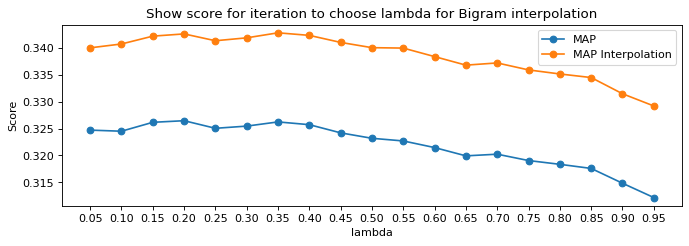

In [ ]:
plt.figure(figsize=(10, 3), dpi=80)
plt.plot(lbs,MAP_alpha,label = 'MAP',marker = 'o')
plt.plot(lbs,MAP_TREC_alpha, label = 'MAP Interpolation', marker = 'o')

plt.title("Show score for iteration to choose lambda for Bigram interpolation")
plt.xlabel('lambda')
plt.ylabel('Score')
plt.xticks(lbs)
plt.legend()
plt.show()


## Compare Result

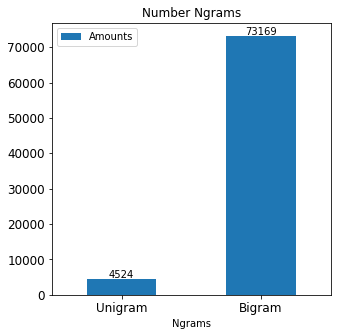

In [ ]:
nums_unigram = len(unigram)
nums_bigram = len(bigram)

df = pd.DataFrame({'Ngrams': ['Unigram','Bigram'],'Amounts': [nums_unigram,nums_bigram]})

ax = df.plot.bar(figsize = (5,5),x = 'Ngrams', y = 'Amounts',rot=0,fontsize = 12)
ax.set_title('Number Ngrams')
for container in ax.containers:
  for c in container:
    ax.annotate(c.get_height(),xy = (c.get_xy()[0] + 0.25,c.get_height() + 1050),va = 'center',ha = 'center')

In [ ]:
score_laplace_uni = Measure(ranked_matrix_laplace_uni,res_matrix,mode = "prob").return_score()
score_inter_uni = Measure(ranked_matrix_inter_uni,res_matrix,mode = "prob").return_score()
score_laplace_big = Measure(ranked_matrix_laplace_big,res_matrix,mode = "prob").return_score()
score_inter_big = Measure(ranked_matrix_inter_big,res_matrix,mode = "prob").return_score()

In [ ]:
score = [score_laplace_uni,score_inter_uni,score_laplace_big,score_inter_big]

In [ ]:
score_inter_big

{'recall': 0.7337113446842959,
 'precision': 0.01183111111111111,
 'MAP': 0.3023851407063515,
 '11 points': 0.36850941730290454}

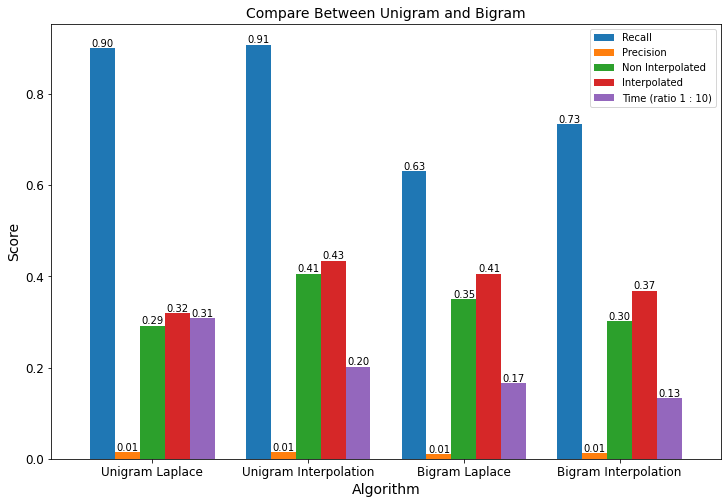

In [ ]:
labels = ['Unigram Laplace', 'Unigram Interpolation']
recall = [s['recall'] for s in score]
precision = [s['precision'] for s in score]
MAP = [s['MAP'] for s in score]
TREC_11_points = [s['11 points'] for s in score]
time = [time_uni_laplace / 10,time_inter_uni / 10,time_laplace_big / 10,time_inter_big / 10]

index = ['Unigram Laplace','Unigram Interpolation','Bigram Laplace','Bigram Interpolation']


df = pd.DataFrame({'Recall': recall,
                   'Precision': precision,
                   'Non Interpolated': MAP,
                   'Interpolated ': TREC_11_points,
                   'Time (ratio 1 : 10)': time}, index=index)



ax = df.plot.bar(figsize = (12,8),rot=0,width = 0.8,fontsize = 12)
ax.set_title('Compare Between Unigram and Bigram',fontsize = 14)
ax.set_xlabel('Algorithm',fontsize = 14)
ax.set_ylabel('Score',fontsize = 14)
for container in ax.containers:
  for c in container:
    ax.annotate('{:.2f}'.format(c.get_height()),xy = (c.get_xy()[0] + 0.01,c.get_height() + 0.01),va = 'center')

In [ ]:
df

,Recall,Precision,Non Interpolated,Interpolated,Time (ratio 1 : 10)
Unigram Laplace,0.898963,0.014418,0.291918,0.319503,0.308131
Unigram Interpolation,0.907434,0.014542,0.405579,0.434017,0.202063
Bigram Laplace,0.630284,0.010142,0.350174,0.405581,0.166339
Bigram Interpolation,0.733711,0.011831,0.302385,0.368509,0.133642


In [ ]:
def get_bigram(docs):
  freq = np.zeros(len(docs))
  bigram = {}
  unigram = {}
  for index_doc,doc in enumerate(docs):
    list_ngram = list(ngrams(doc, 2))
    list_unigram = list(ngrams(doc,1))
    for vector_word in list_ngram:
      bigram[vector_word] = bigram.get(vector_word,{})
      bigram[vector_word][index_doc] = bigram[vector_word].get(index_doc,0) + 1
    for vector_word in list_unigram:
      unigram[vector_word[0]] = unigram.get(vector_word[0],{})
      unigram[vector_word[0]][index_doc] = unigram[vector_word[0]].get(index_doc,0) + 1
    freq[index_doc] = len(list_unigram)

  bigram_matrix = np.zeros((len(bigram),len(docs)),dtype = float)
  key = {vector_word:i for vector_word,i in zip(bigram,range(len(bigram)))}
  inverst_key = {i:vector_word for vector_word,i in zip(bigram,range(len(bigram)))}
  for vector_word in bigram.keys():
    for index_doc in bigram[vector_word].keys():
      bigram_matrix[key[vector_word],index_doc] += bigram[vector_word][index_doc]
  return unigram,bigram,bigram_matrix,freq,inverst_key

In [ ]:
def count_word(unigram,unigram_counts,word):
  word_count = unigram[word]
  for index_doc in word_count.keys():
    unigram_counts[i][index_doc] += word_count[index_doc]   

In [ ]:
def laplace_smooth(bigram,unigram,inverst_key,alpha,freq,V):
  prob_bigram = deepcopy(bigram)
  lb = 0.4
  # prob_bigram += alpha
  unigram_counts_first = np.zeros((len(bigram),len(docs)))
  unigram_counts_second = np.zeros((len(bigram),len(docs)))
  for i in range(bigram.shape[0]):
    vector_word = inverst_key[i]
    first_word = vector_word[0]
    second_word = vector_word[1]
    for index_doc in unigram[first_word].keys():
      unigram_counts_first[i][index_doc] += unigram[first_word][index_doc]
    for index_doc in unigram[second_word].keys():
      unigram_counts_second[i][index_doc] += unigram[second_word][index_doc]  
    count_word(unigram,unigram_counts_second,second_word)
  # prob_bigram = prob_bigram / (unigram_counts_first + alpha * V)
  prob_bigram = lb * np.divide(prob_bigram,unigram_counts_first,where = unigram_counts_first != 0) + (1 - lb) * (unigram_counts_second / freq)
  return prob_bigram

In [ ]:
def get_bigram_query(query_terms,fd,n = 2):
  query_bigram = {}
  for i_q,q in enumerate(query_terms):
    list_ngram = ngrams(q,n)
    query_bigram[i_q] = query_bigram.get(i_q,{})
    for vector_word in list_ngram:
      if vector_word in fd:
        query_bigram[i_q][vector_word] = query_bigram[i_q].get(vector_word,0) + 1
  return query_bigram

In [ ]:
def ranked_document(prob_bigram,query_bigram,key):
  ranked_matrix = np.ones((prob_bigram.shape[1],len(query_bigram.keys())))
  for query_id in query_bigram.keys():
    for vector_word in query_bigram[query_id].keys():
      ranked_matrix[:,query_id] *= np.power(prob_bigram[key[vector_word]]\
      ,query_bigram[query_id][vector_word])
  return np.transpose(ranked_matrix)

In [ ]:
dd = []
for doc in DD:
  dd.append(['<s>',*doc,'</s>'])

In [ ]:
unigram,bigram,bigram_matrix,freq,inverst_key = get_bigram(dd)
prob_bigram = laplace_smooth(bigram_matrix,unigram,inverst_key,1,len(unigram),freq)
query_bigram = get_bigram_query(query_terms,bigram)
key = {vector_word:i for vector_word,i in zip(bigram,range(len(bigram)))}
ranked_matrix = ranked_document(prob_bigram,query_bigram,key)

In [ ]:
score = Measure(ranked_matrix,res_matrix,mode = 'prob')
score.get_score()

Recall score: 0.46467105123846514
Precision score: 0.007324444444444445
MAP score: 0.1663518260979908
Mean interpolation 11 points: 0.39320950716920544


# Whoosh

In [ ]:
!rm -rf ind_whoosh

In [ ]:
!mkdir ind_whoosh

In [ ]:
start = time.time()
from whoosh.index import create_in
from whoosh.fields import *
from whoosh.analysis import StandardAnalyzer

schema = Schema(docid=STORED(), content=TEXT(stored=True))
ix = create_in("ind_whoosh", schema)
writer = ix.writer()
for i in range(len(DD)):
  writer.add_document(docid="{}".format(i+1), content=DD[i])
writer.commit()
end = time.time()
time_whoosh_add = end - start

In [ ]:
start = time.time()
from whoosh import qparser
from whoosh import scoring
import whoosh.index as index

ind = index.open_dir("ind_whoosh")
searcher = ind.searcher(weighting=scoring.TF_IDF())

parser = qparser.QueryParser("content", ind.schema, group=qparser.OrGroup)
result_query = [[]]
for q in query_terms:
  query = parser.parse(" ".join(q))
  results = searcher.search(query, limit=None)
  for result in results:
    result_query[-1].append(int(result["docid"]) - 1)
  result_query.append([])
end = time.time()
time_whoosh_query = end - start

In [ ]:
print(f'Time total of whoosh: {time_whoosh_add + time_whoosh_query}')

Time total of whoosh: 12.955660343170166


In [ ]:
score = Measure(result_query,res_matrix,'whoosh')
score.get_score()

Recall score: 0.9539935156096753
Precision score: 0.009954454011905646
MAP score: 0.25754031194109106
Mean interpolation 11 points: 0.2845509298665359


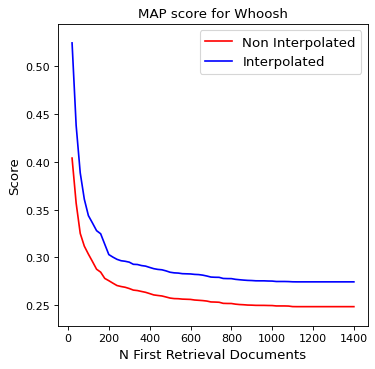

In [ ]:
plot_MAP_M11('MAP score for Whoosh',result_query,res_matrix,mode = 'whoosh')

# Search 

In [ ]:
def getTopDocument(docs,ranked_matrix,k = 10):
  try:
    results = []
    top_k_index_documents = np.argsort(-ranked_matrix[0])[:k]
    for index_doc in top_k_index_documents:
      doc = docs[index_doc]
      score = ranked_matrix[0][index_doc]
      if score == 0:
        return results
      docid = index_doc + 1
      content = {
          'docid': docid,
          'content': doc,
          'score': score
      }
      results.append(content)
    return results
  except:
    return []

In [ ]:
def printResult(docs,ranked_matrix,k = 10):
  start = time.time()
  results = getTopDocument(docs,ranked_matrix,k)
  end = time.time()
  if results != []:
    print(f'Time Find Documents: {end - start}ms')
    print('------------------------------------------------------------------------------------')
    for i in range(len(results)):
      print(f'Top {i + 1} document')
      print('Doc Id: ',results[i]['docid'])
      print('Score: ',results[i]['score'])
      print('Doc content: ',results[i]['content'])
      print('------------------------------------------------------------------------------------')
  else:
    print('Sorry! we dont find any documents relevant with your query')

**Search query by VSM**

In [ ]:
N_docs = len(DD)
term_doc_index = create_term_doc_index(DD,fd)
collect_matrix = create_collect_matrix(term_doc_index)
idf_matrix(collect_matrix,N_docs)
query_collect = deepcopy(collect_matrix)
normalize_docs = normalize_matrix(term_doc_index, collect_matrix)
tfidf_matrix(term_doc_index,collect_matrix, normalize_docs)

In [ ]:
# Receive Query
query_search = input()

# Extractor terms from query
search_terms = get_terms(query_search)
N_querys = len(search_terms)

# Tranform query into vector
query_index = create_term_doc_index([[*search_terms]],fd)
normalize_query = normalize_matrix(query_index, query_collect)
tfidf_matrix(query_index,query_collect, normalize_query)

# Ranked document
ranked_matrix = create_ranked_matrix(term_doc_index,query_index,N_docs,N_querys)

# Get top document receive
printResult(docs,ranked_matrix,5)

area
Time Find Documents: 0.00023412704467773438ms
------------------------------------------------------------------------------------
Top 1 document
Doc Id:  235
Score:  0.45707898973047034
Doc content:  on the minimisation and numerical evaluation of wave drag . a fourier analysis of the linearised theory expression for the zero lift wave drag of a smooth, slender body in terms of its cross sectional area distribution is used to derive the area distribution which minimises the expression for given length, volume, nose area, base area and n intermediate areas .  another minimal deduced from this by relaxing the restriction on volume is used to evolve a method for the numerical evaluation of the original expression . two practical applications of these results are discussed .  the first is in the design of wing body combinations to have small drag rise at transonic speeds .  the second is in the calculation of the wave drag of wing body combinations at zero lift,. an example is constr

**Search query by Language Model**

In [ ]:
collection = []
for doc in DD:
  collection.extend(doc)
lb = 0.4
unigram,freq = get_unigram_docs(DD)
unigram_collection,freq_c = get_unigram_collection(collection)
calProbCollection(unigram_collection,freq_c)
calProbDocument(unigram,freq, unigram_collection,lb = lb)